In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import scipy
from scipy import stats
from scipy.optimize import brentq, least_squares

# Option Smile Calibration using Displaced-Diffusion Model

This notebook demonstrates the use of Displaced-Diffusion (shifted lognormal) Model to fit and calibrate implied volatility smile against observed market data.

In this example, the S&P 500 index options are used. The market data was extracted from WRDS, and the prices were based on 01/12/2020. Due to copyright, the data will not be uploaded onto the GitHub. 

Three expirations are used for this purpose:
- Front month contract: 20201218 Expiry
- Second month contract: 20210115 Expiry
- Third month contract: 20210219 Expiry

All options with valid bid- and offer prices are included. The contract is an European option, which can only be exercised on the day of expiry and not earlier.

The US Zero curve is used as a proxy for the risk-free rate required in the Option Pricing Model.

This is the second notebook fo the Option Smile Calibration series. For a more comprehensive explanation of the background, please refer to `01_Option Smile Calibration using SABR.ipynb`.

## Black-Scholes Option Pricing Model

In [2]:
def black_scholes_option_pricer(S, K, r, T, sigma, call = True):
    '''
    Function calculates option prices based on Black-scholes model.
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*(T))/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    if not call:
        d2 = -d2
        d1 = -d1

    option_values = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return option_values

## Data Extraction and Exploration

Since we are fitting the implied volatility smile of the S&P 500 index option, apart from loading the SPX option prices and the zero curve data, we need to extract the spot price of S&P 500 index on the date of interest.

Here, we are using the `yfinance` package, that scrapes the data from Yahoo finance.

In [3]:
# Load data
spx_prices = pd.read_csv('SPX_options.csv') # SPX Option market data
zero_rates = pd.read_csv('zero_rates_20201201.csv') # Zero curve data

In [4]:
spx_prices.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E


In [5]:
# Get the key dates
ex_dates = spx_prices.exdate.unique()
spot_date = spx_prices.date.unique()[0]

In [6]:
# Extract required spot price from yahoo finance API
query_start = datetime.strptime(str(spot_date), "%Y%m%d").strftime("%Y-%m-%d")
query_end = datetime.strptime(str(spot_date+1), "%Y%m%d").strftime("%Y-%m-%d")

spx_ticker = yf.Ticker("^GSPC")
spx_history = spx_ticker.history(start=query_start, end=query_end)
spx_spot = spx_history["Close"].values[-1]

print('The spot price of S&P 500 index on {} is ${:.2f}.'.format(query_start, spx_spot))

The spot price of S&P 500 index on 2020-12-01 is $3662.45.


In [7]:
def get_AOTM_options(x, spot):
    if x['cp_flag'] == 'C':
        return True if x['strike_price'] >= spot else False
    else:
        return True if x['strike_price'] <= spot else False

In [8]:
spx_prices['strike_price'] *= 0.001
spx_prices['AOTM'] = spx_prices.apply(lambda x: get_AOTM_options(x, spx_spot), axis = 1)
spx_prices.loc[(spx_prices['best_bid'] == 0)].head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,AOTM
400,20201201,20201218,C,4400.0,0.0,0.1,E,True
401,20201201,20201218,C,4500.0,0.0,0.1,E,True
402,20201201,20201218,C,4600.0,0.0,0.1,E,True
403,20201201,20201218,C,4700.0,0.0,0.1,E,True
404,20201201,20201218,C,4800.0,0.0,0.1,E,True


In [9]:
# Get days to expiry
spx_prices['days_to_expiry'] = (pd.to_datetime(spx_prices.exdate, format = '%Y%m%d')-\
                                pd.to_datetime(spx_prices.date, format = '%Y%m%d')).dt.days

print('The days to expiry of the contracts are', spx_prices['days_to_expiry'].unique())

The days to expiry of the contracts are [17 45 80]


Unlike the attempt in the first notebook, we shall directly interpolate the zero rates.

In [10]:
# Attempt to interpolate discount factors for the days to maturity of concern
xp = zero_rates['days'].to_numpy()
fp = zero_rates['rate'].to_numpy()/100
days_to_expiry = np.array([(pd.Timestamp(str(ex_date)) - pd.Timestamp(str(spot_date))).days for ex_date in ex_dates])
required_zero_rates = np.interp(days_to_expiry, xp, fp)

# Packages days-to-expiry (key) and required zero rates (value) into a dictionary
r_dict = dict(zip(days_to_expiry, required_zero_rates))

# Print out the zero rate given days to expiry
print('The zero rates are as follows:')
for key, value in r_dict.items():
    print("{} days: {:.4f}%".format(key, value*100))

The zero rates are as follows:
17 days: 0.1255%
45 days: 0.2051%
80 days: 0.2206%


In [11]:
# Omit data points with 0 best_bid
spx_prices = spx_prices.loc[(spx_prices['best_bid'] != 0)]

# Get only ATM and OTM contracts
spx_prices = spx_prices[spx_prices['AOTM'] == True]
spx_prices = spx_prices.sort_values(by = 'strike_price')

# Get mid prices
spx_prices['mid'] = 0.5*(spx_prices['best_bid'] + spx_prices['best_offer'])

# Calculate required variables for implied vol calculation
spx_prices['T'] = spx_prices['days_to_expiry'] / 365
spx_prices['r'] = spx_prices['days_to_expiry'].apply(lambda x: r_dict[x])
spx_prices['F'] = spx_spot * np.exp(spx_prices['r'] * spx_prices['T'])

In [12]:
def get_implied_volatility(S, option_params):
    # unpack options_params
    payoff = option_params['cp_flag']
    K = option_params['strike_price']
    price = option_params['mid']
    r = option_params['r']
    T = option_params['T']
    
    try:
        if payoff == 'C':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x),
                                1e-12, 10.0)
        elif payoff == 'P':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x,call = False),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized: ', payoff)
    except:
        implied_vol = np.nan
        
    return implied_vol

In [13]:
spx_prices['implied_vol'] = spx_prices.apply(lambda x: get_implied_volatility(spx_spot, x), axis = 1)
spx_prices.dropna(inplace=True)
spx_prices_cleaned = spx_prices[['exdate', 'mid', 'cp_flag','strike_price', 'implied_vol', 'F', 'r', 'T']].copy()

In [14]:
spx_prices_cleaned.head()

,exdate,mid,cp_flag,strike_price,implied_vol,F,r,T
1824,20210219,0.125,P,900.0,0.926749,3664.221424,0.002206,0.219178
1825,20210219,0.200,P,1000.0,0.891176,3664.221424,0.002206,0.219178
1826,20210219,0.275,P,1100.0,0.849821,3664.221424,0.002206,0.219178
1827,20210219,0.350,P,1200.0,0.807115,3664.221424,0.002206,0.219178
1828,20210219,0.450,P,1300.0,0.768691,3664.221424,0.002206,0.219178


Now we are ready to implement the Displaced-Diffusion calibration.

---

## Displaced-Diffusion Model

The displaced-diffusion model for option pricing was first introduced by Mark Rubinstein in 1983. The idea originated from the Black 1976 model, which is an application of the Black-Scholes model on the forward price, as shown in Eq. (1).

$$dF_t = \sigma F_t dW_t \tag{1}$$

The displaced-diffusion model introduces a "shift" parameter $\alpha$ which shifts the lognormal process, in Eq. (2).

$$dF_t = \sigma (F_t + \alpha) dW_t \tag{2}$$

The shift allows the lognormal process to translate along the Y-axis, thus able to set a floor higher than zero which the process cannot trespass (if $\alpha < 0$) or to go into the negative region (if $\alpha < 0$) which it usually cannot.

We shall use another form of the displaced-diffusion model which is more suited for option pricing, as shown in Eq. (3).

$$dF_t = \sigma[\beta F_t + (1 - \beta)F_0]dW_t \tag{3}$$

Here, the stochastic differential equation encompasses two different stochastic processes, namely
1. arithmetic Brownian motion (ABM), represented by $\sigma F_0 dW_t$
2. geometric Brownian motion (GBM), $\sigma F_t dW_t$

The two Brownian motions were added together with ratio of $\frac{\beta}{1 - \beta}$, $\beta$ is a tuning parameter that adds weight onto the GBM. When $\beta = 1$, the process is fully lognormal (the typical Black-Scholes Model) whereas when $\beta = 0$ the process is fully normal (Bachelier Model). Typically $\beta \in (0,1)$.

In [15]:
def displaced_diffusion_option_pricer(F, K, r, T, sigma, beta, call):
    ''' 
    Function calculates option prices based on Displaced-Diffusion Model.
    Three modes available: Vanilla (default), Cash-or-Nothing (CON), Asset-or-Nothing (AON)
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: short rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    beta: parameter to adjust degree of "mixture" between geometric and arithmetic BM
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    # Calculate d1 and d2
    d2 = (np.log(F/(beta*(K+(1-beta)/beta*F))) - (np.square(beta*sigma)*T)/2)/(beta*sigma * np.sqrt(T))
    d1 = d2 + sigma*beta*np.sqrt(T)

    #initializing d1 & d2 for call and put
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1

    #calculating the option values
    option_values = F/beta*scipy.stats.norm.cdf(d1) - (K+(1-beta)/beta*F)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return np.exp(-r*T)*option_values

In [16]:
def displaced_diffusion_calibration(x, strikes, cp_flag, vols, F, r, T, vol_atm, weights = np.empty(0)):
    err = 0.0
    
    if not weights.size:
        weights = np.ones(strikes.shape[0])

    for i, K in enumerate(strikes):
        if weights[i]:
            flag = True if cp_flag.iloc[i] == 'C' else False
            dd_price = displaced_diffusion_option_pricer(F, K, r, T, vol_atm, x, call = flag)
            dd_imp_vol = brentq(lambda y: dd_price - black_scholes_option_pricer(F*np.exp(-r*T), K, r, T, y, call = flag),
                                    1e-12, 10.0)
            err += weights[i]*(vols.iloc[i] - dd_imp_vol)**2

    return err

In [17]:
def plotter(df, DD_vols, exdate, underlying):
    plt.figure(figsize = (8,4))

    plt.plot(df['strike_price'], df['implied_vol'], 'gs', label='Market Vols')
    plt.plot(df['strike_price'], DD_vols, 'm--', label='Displaced-Diffusion Vols')

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title("Implied volatility Smile of {0} options (expiring {1})".format(underlying, exdate))
    plt.legend()
    
    plt.show()

Recall that a typical calibration exercise entails the following steps

1. Define the desired option pricing model
2. With the known variables and an initial guess of the model parameters, compute the option prices and implied volatilities
3. Compare the computed option prices and implied volatilities with market prices and implied volatilities
4. Update the model parameters using selected optimization algorithm to minimize the loss function
5. Repeat steps 2 to 4 with the new guesses until the model is optimized to achieve below a maximum tolerable error


Now calibrate market prices for expiry = 20201218...
ATM Vol for expiration date 20201218 is 0.17440921085737124!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
The cost of the optimization (half of sum of squares), C =  373.50447697096763
Plotting...


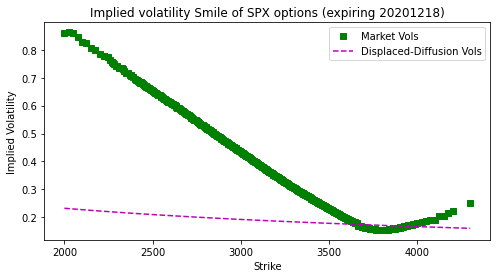

Now calibrate market prices for expiry = 20210115...
ATM Vol for expiration date 20210115 is 0.18482902882513988!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
The cost of the optimization (half of sum of squares), C =  78.08166331855223
Plotting...


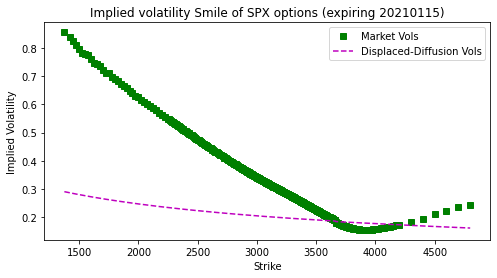

Now calibrate market prices for expiry = 20210219...
ATM Vol for expiration date 20210219 is 0.19018024467291345!
Calibrated Displaced-Diffusion model parameters: beta = 0.000
The cost of the optimization (half of sum of squares), C =  18.229632774188083
Plotting...


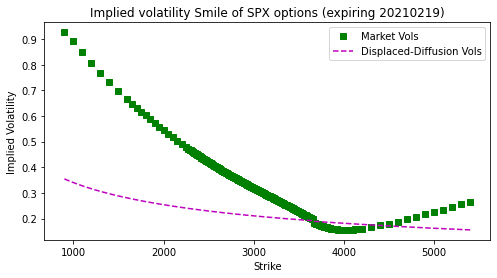

In [18]:
DD_calibration = []

for ex_date in ex_dates:
    print('Now calibrate market prices for expiry = {}...'.format(ex_date))
    res_dict = {'Expiry': ex_date}
    
    df_to_calibrate = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == ex_date].copy()
    df_to_calibrate = df_to_calibrate
    
    # Obtain necessary option parameters
    ATM_vol_plus = df_to_calibrate[df_to_calibrate['strike_price']>spx_spot]['implied_vol'].iloc[0]
    ATM_vol_minus = df_to_calibrate[df_to_calibrate['strike_price']<spx_spot]['implied_vol'].iloc[-1]

    ATM_vol = 0.5*(ATM_vol_plus + ATM_vol_minus)
    
    print('ATM Vol for expiration date {0} is {1}!'.format(ex_date, ATM_vol))
    
    F = df_to_calibrate['F'].unique()[0]
    r = df_to_calibrate['r'].unique()[0]
    T = df_to_calibrate['T'].unique()[0]
    
    # Initial Guess for model parameter
    DD_guess_0 = [1.0]
    
    # Calibrate Model to market observed Implied Vol
    DD_res = least_squares(lambda x: displaced_diffusion_calibration(x,
                                                                     df_to_calibrate['strike_price'],
                                                                     df_to_calibrate['cp_flag'],
                                                                     df_to_calibrate['implied_vol'],
                                                                     F,
                                                                     r,
                                                                     T,
                                                                     ATM_vol),
                           DD_guess_0, bounds= (1e-10,2))
    
    DD_beta= DD_res.x[0]
    
    print('Calibrated Displaced-Diffusion model parameters: beta = %.3f' % (DD_beta))
    print('The cost of the optimization (half of sum of squares), C = ',  DD_res.cost)
    
    # Derive implied vol per strike for OTM and ATM options
    DD_vols = []
    for i, K in enumerate(df_to_calibrate['strike_price']):
            flag = True if df_to_calibrate.cp_flag.iloc[i] == 'C' else False
            opt_val = displaced_diffusion_option_pricer(spx_spot,
                                                        K, 
                                                        r, 
                                                        T, 
                                                        ATM_vol, 
                                                        DD_beta, 
                                                        call = flag)
            
            DD_implied_vol = brentq(lambda x: opt_val - black_scholes_option_pricer(spx_spot, 
                                                                                        K, 
                                                                                        r, 
                                                                                        T, 
                                                                                        x, 
                                                                                        call = flag),
                                    1e-12, 10.0)
            DD_vols.append(DD_implied_vol)
    
    res_dict['ATM_Vol'] = ATM_vol
    res_dict['beta'] = DD_beta
    
    print('Plotting...')
    plotter(df_to_calibrate,\
            DD_vols,\
            ex_date,\
            'SPX')
    
    DD_calibration.append(res_dict)

In [19]:
df_DD = pd.DataFrame(DD_calibration)
df_DD.set_index('Expiry', inplace=True)
df_DD

,ATM_Vol,beta
Expiry,,
20201218,0.174409,8.672034e-07
20210115,0.184829,1.000001e-10
20210219,0.190180,1.753698e-07


In the calibration, we set $\beta$ to be between 0 and 1. Our calibrated $\beta$ ended up to be virtually zero, which implies that the model was fitted to become almost like a Bachelier Option Pricing Model.

To understand why the calibrated $\beta$ is 0, we need to analyze the effect of $\beta$ on the implied volatility skew. We shall vary $\beta$ in the following demonstration, for the given set of option parameters. We shall explore $\beta \in \{0.1, 0.3, 0.5, 0.7, 0.9\}$.

In [20]:
strikes = np.arange(2000, 5000, 100)
ATM_vol =  df_DD.loc[20201218, 'ATM_Vol']
T = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == 20201218, 'T'].unique()[0]
r = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == 20201218, 'r'].unique()[0]
ls_beta = []


for beta in np.arange(0.1, 1, 0.2):
    res_beta = []
    for K in strikes:
        call = True if K > spx_spot else False
        opt_val = displaced_diffusion_option_pricer(spx_spot,
                                                    K, 
                                                    r, 
                                                    T, 
                                                    ATM_vol, 
                                                    beta, 
                                                    call)

        DD_implied_vol = brentq(lambda x: opt_val - black_scholes_option_pricer(spx_spot, 
                                                                                    K, 
                                                                                    r, 
                                                                                    T, 
                                                                                    x, 
                                                                                    call),
                                1e-12, 10.0)
    
        res_beta.append(DD_implied_vol)
    
    res_beta = np.array(res_beta)
    ls_beta.append(res_beta)

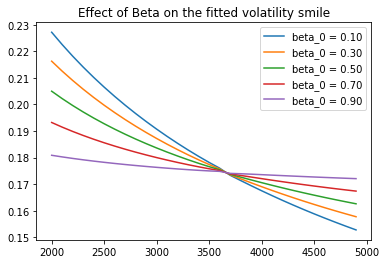

In [21]:
plt.title('Effect of Beta on the fitted volatility smile')
for arr, beta in zip(ls_beta, np.arange(0.1, 1, 0.2)):
    plt.plot(strikes, arr, label = 'beta_0 = {:.2f}'.format(beta))
plt.legend()
plt.show()

From the above experiment, we can observe that $\beta$ adjusts for the slope of the skew. The smaller the value of beta, the more negative the gradient of the fitted curve.

However, there is only one degree of freedom that can be varied to fit the market observation. However, adjusting of $\beta$ cannot help to fit the curvature. This is the reason our calibrated $\beta$ becomes close to zero, in order to fit the negative slope on the left and the positive slope on the right. 

As explained in `01_Option Smile Calibration using SABR.ipynb`, the volatility smile was caused by the need for downside protection using OTM puts and speculative activities in the OTM calls. Nearer dated options tend to exhibit stronger smile as there are more speculative activities in the options. 

This shows that the displaced-diffusion model may not be suitable to fit the smile of near-dated options.

In the following, we shall explore limiting the fit to near ATM options (As far OTM options may be less traded for contracts that are about to expire). Also, we expanded the range of $\beta$ to allow it to go into negative. Models with negative $\beta$ are known as 'supernormal'.

In [22]:
def get_quick_delta(F, K, ATM_vol, T):
    numer = np.log(F/K)
    denom = ATM_vol * np.sqrt(T)
    
    return scipy.stats.norm.cdf(numer/denom)

Now calibrate market prices for expiry = 20201218...
ATM Vol for expiration date 20201218 is 0.17440921085737124!


C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


Calibrated Displaced-Diffusion model parameters: beta = -1.993
The cost of the optimization (half of sum of squares), C =  1.5318896858807745e-07
Plotting...


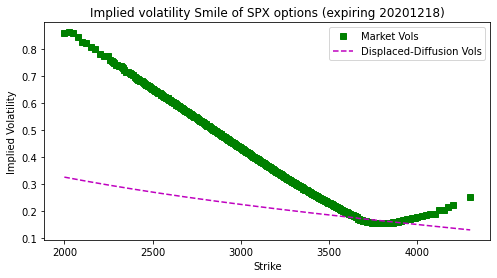

Now calibrate market prices for expiry = 20210115...
ATM Vol for expiration date 20210115 is 0.18482902882513988!


C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


Calibrated Displaced-Diffusion model parameters: beta = -1.981
The cost of the optimization (half of sum of squares), C =  9.16453675926542e-07
Plotting...


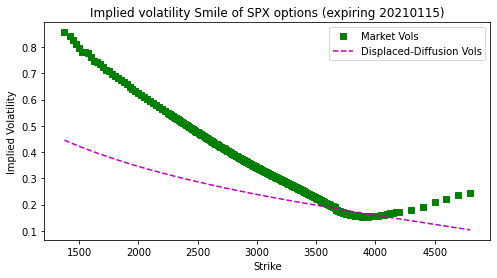

Now calibrate market prices for expiry = 20210219...
ATM Vol for expiration date 20210219 is 0.19018024467291345!


C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply
C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


Calibrated Displaced-Diffusion model parameters: beta = -2.000
The cost of the optimization (half of sum of squares), C =  1.5137199650093162e-06
Plotting...


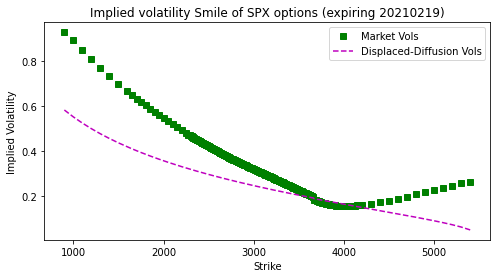

In [23]:
DD_calibration = []

for ex_date in ex_dates:
    print('Now calibrate market prices for expiry = {}...'.format(ex_date))
    res_dict = {'Expiry': ex_date}
    
    df_to_calibrate = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == ex_date].copy()
    
    ATM_vol_plus = df_to_calibrate[df_to_calibrate['strike_price']>spx_spot]['implied_vol'].iloc[0]
    ATM_vol_minus = df_to_calibrate[df_to_calibrate['strike_price']<spx_spot]['implied_vol'].iloc[-1]

    ATM_vol = 0.5*(ATM_vol_plus + ATM_vol_minus)
    
    print('ATM Vol for expiration date {0} is {1}!'.format(ex_date, ATM_vol))
    
    F = df_to_calibrate['F'].unique()[0]
    r = df_to_calibrate['r'].unique()[0]
    T = df_to_calibrate['T'].unique()[0]
    
    QD = get_quick_delta(F, df_to_calibrate['strike_price'], ATM_vol, T)
    weights = np.array([1 if 0.4 < x < 0.6 else 0 for x in QD])
    DD_guess_0 = [1.0]
    
    DD_res = least_squares(lambda x: displaced_diffusion_calibration(x,
                                                                     df_to_calibrate['strike_price'],
                                                                     df_to_calibrate['cp_flag'],
                                                                     df_to_calibrate['implied_vol'],
                                                                     F,
                                                                     r,
                                                                     T,
                                                                     ATM_vol,
                                                                    weights),
                           DD_guess_0, bounds= (-2,2))
    
    DD_beta= DD_res.x[0]
    
    print('Calibrated Displaced-Diffusion model parameters: beta = %.3f' % (DD_beta))
    print('The cost of the optimization (half of sum of squares), C = ',  DD_res.cost)
    
    DD_vols = []
    for i, K in enumerate(df_to_calibrate['strike_price']):
            flag = True if df_to_calibrate.cp_flag.iloc[i] == 'C' else False
            opt_val = displaced_diffusion_option_pricer(spx_spot,
                                                        K, 
                                                        r, 
                                                        T, 
                                                        ATM_vol, 
                                                        DD_beta, 
                                                        call = flag)
            
            DD_implied_vol = brentq(lambda x: opt_val - black_scholes_option_pricer(spx_spot, 
                                                                                        K, 
                                                                                        r, 
                                                                                        T, 
                                                                                        x, 
                                                                                        call = flag),
                                    1e-12, 10.0)
            DD_vols.append(DD_implied_vol)
            
    res_dict['beta'] = DD_beta
    
    print('Plotting...')
    plotter(df_to_calibrate,\
            DD_vols,\
            ex_date,\
            'SPX')
    
    DD_calibration.append(res_dict)

In [24]:
df_DD = pd.DataFrame(DD_calibration)
df_DD.set_index('Expiry', inplace=True)
df_DD

,beta
Expiry,
20201218,-1.993127
20210115,-1.981309
20210219,-1.999905


---
# References
Rubinstein, M. (1983). Displaced Diffusion Option Pricing. The Journal of Finance, 38(1), 213–217. https://doi.org/10.2307/2327648